In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os

import warnings
warnings.filterwarnings('ignore')

In [5]:
log_dir = '/scratch/midway3/jshe/molecular-attention-bias/U_G'

## Load data from log directory

In [6]:
logs = []
for root, dirs, files in os.walk(log_dir):
    if not files: continue
    *_, model_type, radial_function_type, architecture, run_id = root.split('/')
    run_id = run_id.replace('_', '')

    log_file = os.path.join(root, 'log.csv')
    model_file = os.path.join(root, 'model.pt')

    log = pd.read_csv(log_file)
    log.columns = [f'{model_type}_{radial_function_type}_{architecture}_{col}_{run_id}' for col in log.columns]
    logs.append(log)

logs = pd.concat(logs, axis=1)
tuples = [tuple(col.split('_')) for col in logs.columns]
logs.columns = pd.MultiIndex.from_tuples(
    tuples, 
    names=['model_type', 'radial_function_type', 'architecture', 'split', 'property', 'metric', 'run_id']
)

## Single model ensemble loss curves

In [7]:
model_type = 'FixedAttentionTransformer'
radial_function_type = 'PowerLaw'
architecture = 'E64H8D8'

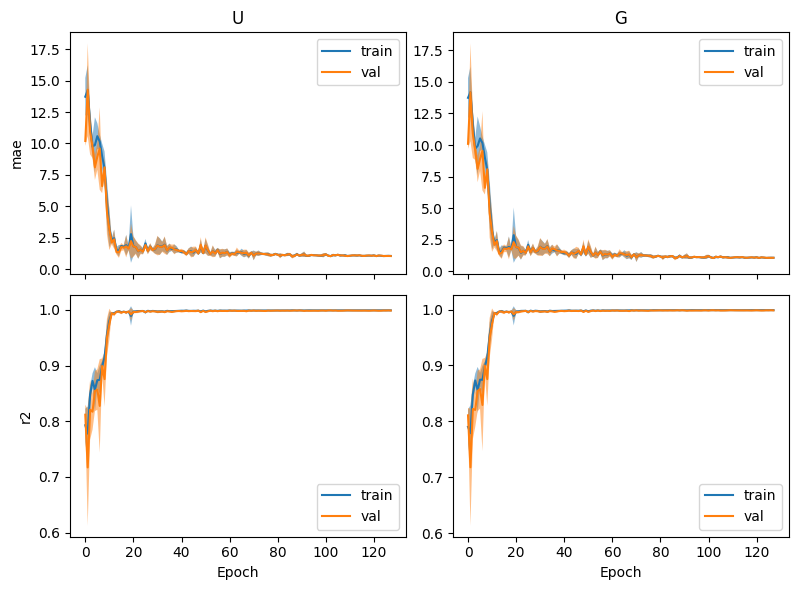

In [8]:
splits = logs.columns.get_level_values('split').unique()
properties = logs.columns.get_level_values('property').unique()
metrics = logs.columns.get_level_values('metric').unique()

fig, axs = plt.subplots(
    len(metrics), len(properties), 
    figsize=(len(properties) * 4, len(metrics) * 3), 
    sharex=True
)

for column, property in enumerate(properties):
    axs[0, column].set_title(property)
    for row, metric in enumerate(metrics):
        axs[row, 0].set_ylabel(metric)
        if row == len(metrics) - 1: axs[row, column].set_xlabel('Epoch')
        for split in splits:
            ax = axs[row, column]

            log = logs[model_type, radial_function_type, architecture, split, property, metric]
            # for run_id in log.columns:
            #     color = 'r' if split == 'train' else 'b'
            #     ax.plot(log[run_id], color=color)
            
            mean = log.mean(axis=1)
            std = log.std(axis=1)
            ax.plot(mean, label=split)
            ax.fill_between(x=range(len(log)), y1=mean - std, y2=mean + std, alpha=0.5)
            ax.legend()
            #if metric == 'mae': ax.set_yscale('log')

fig.tight_layout()

## Ensemble loss distributions

In [11]:

def plot_boxplots(models):
    properties = logs.columns.get_level_values('property').unique()
    metrics = logs.columns.get_level_values('metric').unique()

    fig, axs = plt.subplots(len(properties), 1, figsize=(max(len(models), 4), 4) )

    for row, property in enumerate(properties):
        axs[row].set_title(property)
        axs[row].set_ylabel('MAE (Hartree)')

        tick_labels, data = [], []
        for label, model_type, radial_function_type, architecture in models:
            tick_labels.append(label)
            ensemble = logs[model_type, radial_function_type, architecture, 'val', property, 'mae'].dropna()
            ensemble_means = ensemble.apply(lambda col: col.nsmallest(4)).mean()
            data.append(ensemble_means.to_list())

        axs[row].boxplot(data, tick_labels=tick_labels)

    fig.tight_layout()

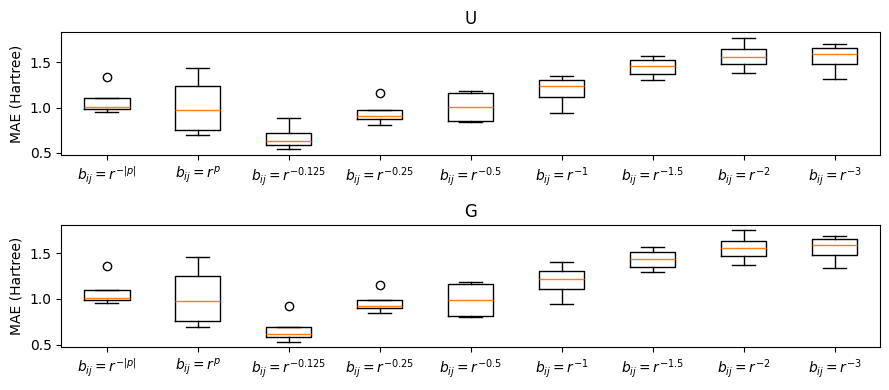

In [15]:
models = [
    ('$b_{ij} = r^{-|p|}$', 'BiasedAttentionTransformer', 'ExpNegativePowerLaw', 'E64H8D8'), 
    ('$b_{ij} = r^{p}$', 'BiasedAttentionTransformer', 'PowerLaw', 'E64H8D8'), 
    #('$b_{ij} = r^{p}$', 'BiasedAttentionTransformer', 'PowerLaw', 'E128H8D2'), 
    ('$b_{ij} = r^{-0.125}$', 'BiasedAttentionTransformer', 'FixedPowerLaw-0.125', 'E64H8D8'),

    ('$b_{ij} = r^{-0.25}$', 'BiasedAttentionTransformer', 'FixedPowerLaw-0.25', 'E64H8D8'),
    ('$b_{ij} = r^{-0.5}$', 'BiasedAttentionTransformer', 'FixedPowerLaw-0.5', 'E64H8D8'), 
    ('$b_{ij} = r^{-1}$', 'BiasedAttentionTransformer', 'FixedPowerLaw-1', 'E64H8D8'),
    ('$b_{ij} = r^{-1.5}$', 'BiasedAttentionTransformer', 'FixedPowerLaw-1.5', 'E64H8D8'), 
    ('$b_{ij} = r^{-2}$', 'BiasedAttentionTransformer', 'FixedPowerLaw-2', 'E64H8D8'), 
    ('$b_{ij} = r^{-3}$', 'BiasedAttentionTransformer', 'FixedPowerLaw-3', 'E64H8D8'), 
]
plot_boxplots(models)

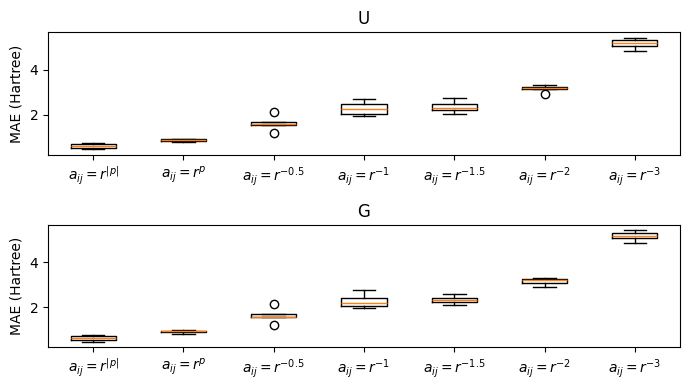

In [13]:
models = [
    ('$a_{ij} = r^{|p|}$', 'FixedAttentionTransformer', 'ExpNegativePowerLaw', 'E64H8D8'), 
    ('$a_{ij} = r^{p}$', 'FixedAttentionTransformer', 'PowerLaw', 'E64H8D8'), 
    ('$a_{ij} = r^{-0.5}$', 'FixedAttentionTransformer', 'FixedPowerLaw-0.5', 'E64H8D8'), 
    ('$a_{ij} = r^{-1}$', 'FixedAttentionTransformer', 'FixedPowerLaw-1', 'E64H8D8'), 
    ('$a_{ij} = r^{-1.5}$', 'FixedAttentionTransformer', 'FixedPowerLaw-1.5', 'E64H8D8'), 
    ('$a_{ij} = r^{-2}$', 'FixedAttentionTransformer', 'FixedPowerLaw-2', 'E64H8D8'), 
    ('$a_{ij} = r^{-3}$', 'FixedAttentionTransformer', 'FixedPowerLaw-3', 'E64H8D8'), 
]
plot_boxplots(models)

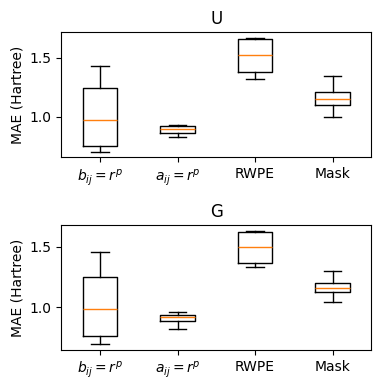

In [14]:
models = [
    ('$b_{ij} = r^{p}$', 'BiasedAttentionTransformer', 'PowerLaw', 'E64H8D8'), 
    ('$a_{ij} = r^{p}$', 'FixedAttentionTransformer', 'PowerLaw', 'E64H8D8'), 
    ('RWPE', 'GraphPETransformer', 'RandomWalkPE16', 'E64H8D8'), 
    ('Mask', 'GraphAttentionTransformer', 'Mask', 'E64H8D8'), 
]
plot_boxplots(models)